### 1.Questions
1) In 2017 was the country an important factor for the possibility to work from home?
2) Which formal education allows most workers to have a remote job?
3) Do smaller companies offer working remotely more often?
4) What are the determining factors in predicting if working from home is possible?

### 2.Extract necessary data

First, let's read in the data and the necessary libraries.

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import os

%matplotlib inline

I decided to work with the Stackoverflow survey 2017 as it contains the information about working from home that I am most curious about

In [85]:
print(os.getcwd())  # get current working directory


c:\Users\Ramona\Documents\Vs_code projects\Udacity_project\udacity-data-science-project-1\notebooks


In [4]:
# Step 1: Load in data
df = pd.read_csv("../data/survey_results_public.csv")
# Take a look at the data
df.head()


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# check the number of rows and columns
num_rows_n = df.shape[0]  # Provide the number of rows in the dataset
num_cols_n = df.shape[1]  # Provide the number of columns in the dataset
print(f"Number of rows: {num_rows_n} \nNumber of columns: {num_cols_n}")


Number of rows: 51392 
Number of columns: 157


In [87]:
# Taking a look at numeric data
df.describe()


,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary,OftenHome,RemotePossible
count,51392.000000,42695.000000,40376.000000,20600.000000,36592.000000,12891.000000,2566.000000,51392.000000,51392.000000
mean,25696.500000,7.300574,6.957078,3.952282,8.429875,56298.480641,33142.220468,0.548412,0.548412
std,14835.736854,1.955444,2.167652,7.564722,1.390635,39880.905277,30162.988829,0.497656,0.497656
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12848.750000,6.000000,6.000000,1.000000,8.000000,26440.371839,4490.492484,0.000000,0.000000
50%,25696.500000,8.000000,7.000000,1.000000,9.000000,50000.000000,29364.263691,1.000000,1.000000
75%,38544.250000,9.000000,8.000000,4.000000,10.000000,80000.000000,50403.225806,1.000000,1.000000
max,51392.000000,10.000000,10.000000,40.000000,10.000000,197000.000000,187500.000000,1.000000,1.000000


In [88]:
# Load in schema
schema = pd.read_csv("../data/survey_results_schema.csv")
schema.head()


,Column,Question
0,Respondent,Respondent ID number
1,Professional,Which of the following best describes you?
2,ProgramHobby,Do you program as a hobby or contribute to ope...
3,Country,In which country do you currently live?
4,University,"Are you currently enrolled in a formal, degree..."


For the 4 questions that I want to answer, I need to have a deeper understanding of the variables HomeRemote, Country, Profession, Company Size. 
 I will take most of the above numeric datapoints in for prediction of Working Remote possibilies.

### Look at necessary data to answer the above questions

In [89]:
def get_description(column_name, schema=schema):
    """
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT -
            desc - string - the description of the column
    """
    desc = list(schema[schema["Column"] == column_name]["Question"])[0]
    return desc

In [90]:
# Get description for all important variables
get_description(
   'HomeRemote'
)  
#,'JobSatisfaction'

'How often do you work from home or remotely?'

In [91]:
df.HomeRemote.dtypes

dtype('O')

A few days each month                                      15454
Never                                                      13975
All or almost all the time (I'm full-time remote)           4905
Less than half the time, but at least one day each week     4147
More than half, but not all, the time                       1909
It's complicated                                            1849
About half the time                                         1769
Name: HomeRemote, dtype: int64


Text(0.5, 1.0, 'How often do you work from home or remotely?')

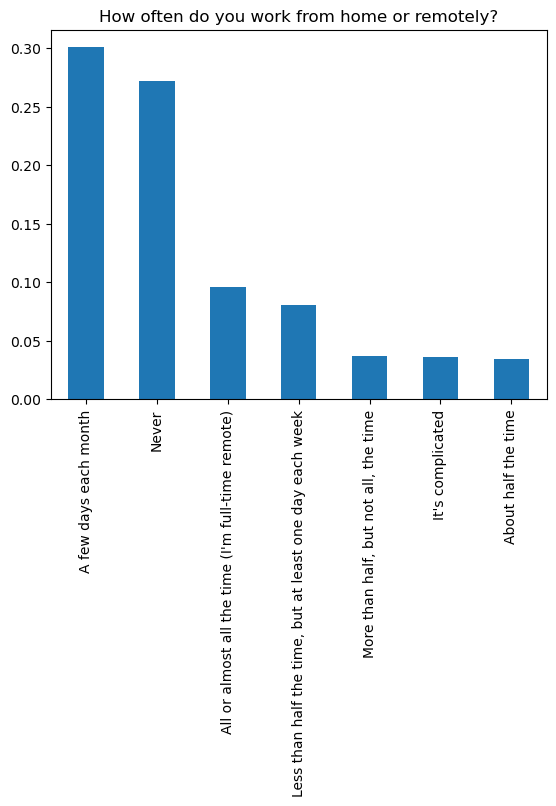

In [9]:
# some graphs for Home Remote
status_vals = df.HomeRemote.value_counts()
print(status_vals)
(status_vals / df.shape[0]).plot(kind="bar")
plt.title("How often do you work from home or remotely?")


In [92]:
# How do the answers look like?
hr = df["HomeRemote"].value_counts().reset_index()
hr.head()


,index,HomeRemote
0,A few days each month,15454
1,Never,13975
2,All or almost all the time (I'm full-time remote),4905
3,"Less than half the time, but at least one day ...",4147
4,"More than half, but not all, the time",1909


### Data Cleaning and Preparation

In [93]:
# To prepare data cleaning we first need to know how many answers we have to the Home Remote question
prop_home_remote = 1 - df.isnull()['HomeRemote'].mean()
prop_home_remote

0.8563200498132005

~86% of participants, answered the question. As this will be my outcome variable I want to predict on later, I decide to delete rows with no answers on the HomeRemote question

In [94]:
hr = df.dropna(subset=["HomeRemote"], axis=0)
# check
1 - hr.isnull()["HomeRemote"].mean()

1.0

#### The above values do not really help to answer my first question, that is why I decided to categorize the answers

In [95]:
# In order to predict working from home later, I decide to create a new categorical variable
def remote_possible(home_cat):
    """
    INPUT
        home_cat - HomeRemote categorical input

    OUTPUT
        return 1 if the category falls into 'it is possible to work from home without problems'
        return 0 otherwise

    """
    if home_cat in ("A few days each month","All or almost all the time (I'm full-time remote)","More than half, but not all, the time","About half the time","Less than half the time, but at least one day each week"):
        return 1
    else:
        return 0


hr["HomeRemote"].apply(remote_possible)[
    :5
]  # Test your function to assure it provides 1 and 0 values for the df

1    1
2    1
3    1
4    0
6    1
Name: HomeRemote, dtype: int64

In [96]:
# perc
hr['RemotePossible'] = hr["HomeRemote"].apply(remote_possible)
remote_perc = hr['RemotePossible'].mean()
remote_perc

C:\Users\Ramona\AppData\Local\Temp\ipykernel_18652\2329484819.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr['RemotePossible'] = hr["HomeRemote"].apply(remote_possible)


0.6404290129067443

64% of the respondents are able to work from home.

For the second question I am  interested in country data 

Text(0.5, 1.0, 'Country')

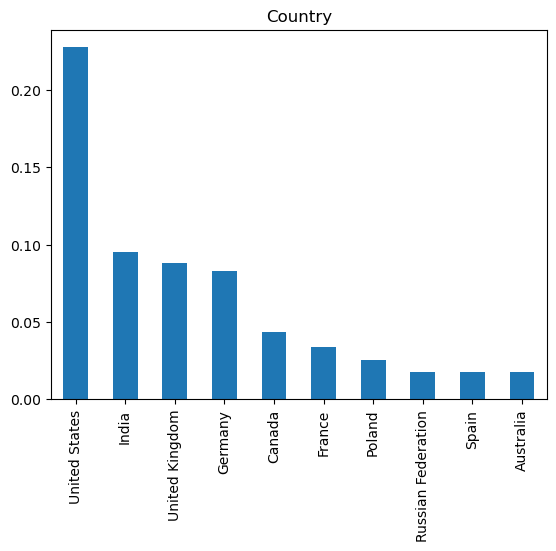

In [98]:
# First, I will look at the top 10 countries of participants
count_vals = hr.Country.value_counts()

(count_vals[:10] / hr.shape[0]).plot(kind="bar")
plt.title("Country")


In [99]:
rp_country = hr.groupby(["Country"]).mean()["RemotePossible"].sort_values().dropna()
rp_country

Country
Cayman Islands      0.0
Saint Lucia         0.0
Reunion (French)    0.0
Bermuda             0.0
Falkland Islands    0.0
                   ... 
Swaziland           1.0
Eritrea             1.0
Macau               1.0
Cape Verde          1.0
Sudan               1.0
Name: RemotePossible, Length: 188, dtype: float64

The above values do not give any insights, I have to restrict the countries to the top 10 to get the insightes I am searching for

In [100]:
hr["country_groups"] = np.where(
    hr["Country"].isin(
        ["United States", "India", "United Kingdom", "Germany", "France", "Canada","Poland","Australia","Russian Federation","Spain"]
    ),
    hr["Country"],
    "Other",
)

C:\Users\Ramona\AppData\Local\Temp\ipykernel_18652\3369174695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr["country_groups"] = np.where(


In [69]:
# To answer the first question, I will have a look at different countries
hr.groupby(["country_groups"]).mean()["RemotePossible"].sort_values().dropna()

country_groups
France                0.474916
Spain                 0.505089
Germany               0.568767
United Kingdom        0.583870
India                 0.640867
Australia             0.643041
Other                 0.647480
Canada                0.647520
Poland                0.677591
United States         0.699581
Russian Federation    0.735369
Name: RemotePossible, dtype: float64

### Evaluation of question 1) In 2017 was the country an important factor for the possibility to work from home?

Interestingly in Russia ~74%  of workers have the possibility to work from home, second rank is United States (~70%), 
Lowest rates for remote workers are in France (~47%) and Spain ~51%. Most likely this changed after 2017 with the Corona pandemic. 

In [101]:
#For the second question I will have a look at the profession and the education 
hr.groupby(['FormalEducation']).mean()['RemotePossible'].sort_values().dropna()

FormalEducation
Secondary school                                                     0.611096
Professional degree                                                  0.622291
Master's degree                                                      0.629324
Bachelor's degree                                                    0.635421
I prefer not to answer                                               0.641949
Some college/university study without earning a bachelor's degree    0.668595
Primary/elementary school                                            0.708934
Doctoral degree                                                      0.713580
I never completed any formal education                               0.726073
Name: RemotePossible, dtype: float64

### Evaluation of question 2) Does higher formal education allows most workers to have a remote job?
No, the respondents of 'I never completed any formal education have the highest remote working scores. Primary/elementary school also ranks in the top 3. It is save to say that there is no positive relationship with working from home and formal education level. 

In [102]:
#For the third question I will have a look at the company size
hr.groupby(['CompanySize']).mean()['RemotePossible'].sort_values().dropna()

CompanySize
I prefer not to answer      0.551111
100 to 499 employees        0.581351
I don't know                0.582367
20 to 99 employees          0.584470
1,000 to 4,999 employees    0.585487
5,000 to 9,999 employees    0.589888
500 to 999 employees        0.594845
10 to 19 employees          0.629123
10,000 or more employees    0.637053
Fewer than 10 employees     0.680515
Name: RemotePossible, dtype: float64

### Evaluation of question 3) Do smaller companies offer working remotely more often?
The answer is no, there is no linear trends in smaller companies having a higher probability to work from home. The smallest companies have the highest percentile of remote workers (68%). However they are directly followed by the biggest companies. Second rank with 64% are companies with more than 10,000 employees.

In [103]:
# correlation table for numeric variables and our outcome variable 
# df_corr = df[["JobSatisfaction", "Salary", "HoursPerWeek"]]
corr = hr[
    [
        "JobSatisfaction",
        "Salary",
        "HoursPerWeek",
        "RemotePossible"
    ]
].corr()
corr.style.background_gradient(cmap="coolwarm")

,JobSatisfaction,Salary,HoursPerWeek,RemotePossible
JobSatisfaction,1.000000,0.120842,-0.081679,0.102625
Salary,0.120842,1.000000,-0.120332,0.163761
HoursPerWeek,-0.081679,-0.120332,1.000000,0.036147
RemotePossible,0.102625,0.163761,0.036147,1.000000


### For the prediction question, I first need to clean the data, that we take into account for the prediction.

In [104]:
def clean_data(hr):
    """
    INPUT
    df - pandas dataframe

    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector

    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    """
    # Define possibility to work from home as y 
    y = hr["RemotePossible"]

    # Drop respondent id
    hr = hr.drop(["Respondent","HomeRemote","RemotePossible"], axis=1)

    # Fill numeric columns with the mean
    num_vars = hr.select_dtypes(include=["float", "int"]).columns
    for col in num_vars:
        hr[col].fillna((hr[col].mean()), inplace=True)

    # Dummy the categorical variables
    cat_vars = hr.select_dtypes(include=["object"]).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        hr = pd.concat(
            [
                hr.drop(var, axis=1),
                pd.get_dummies(hr[var], prefix=var, prefix_sep="_", drop_first=True),
            ],
            axis=1,
        )

    X = hr
    return X, y

In [105]:
X, y = clean_data(hr)    

In [106]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.30, random_state=42)
lm_model = LinearRegression(normalize=True)

In [107]:
X_train

,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary,OftenHome,Professional_Professional developer,Professional_Professional non-developer who sometimes writes code,Professional_Student,...,country_groups_Canada,country_groups_France,country_groups_Germany,country_groups_India,country_groups_Other,country_groups_Poland,country_groups_Russian Federation,country_groups_Spain,country_groups_United Kingdom,country_groups_United States
18787,7.0,6.0,3.566389,8.000000,56296.698228,35471.788965,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
38552,5.0,3.0,0.000000,8.453126,56296.698228,35471.788965,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1133,7.0,9.0,3.566389,6.000000,56296.698228,35471.788965,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
19466,8.0,7.0,1.000000,9.000000,35000.000000,35471.788965,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4212,4.0,3.0,3.566389,10.000000,3303.479665,35471.788965,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7127,9.0,9.0,3.566389,8.000000,56296.698228,35471.788965,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
13079,7.0,1.0,2.000000,7.000000,56296.698228,35471.788965,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
44569,7.0,4.0,14.000000,8.000000,56296.698228,35471.788965,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
986,6.0,7.0,2.000000,8.000000,160000.000000,35471.788965,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [113]:
reg = LogisticRegression().fit(X_train.values, y_train.values)
y_pred = reg.predict(X_test.values)

In [114]:
confusion_matrix(y_test, np.where(y_pred<0.5, 0, 1)) #if I don't specify the threshold, the model will predict for everyone to have the possibility to work from home  

array([[   0, 4658],
       [   0, 8545]], dtype=int64)

In [115]:
target_names = ['no remote work', 'possibility to work from home']
print(classification_report(y_test, np.where(y_pred<0.5, 0, 1), target_names=target_names)) # accuracy is at 65% with the method

                               precision    recall  f1-score   support

               no remote work       0.00      0.00      0.00      4658
possibility to work from home       0.65      1.00      0.79      8545

                     accuracy                           0.65     13203
                    macro avg       0.32      0.50      0.39     13203
                 weighted avg       0.42      0.65      0.51     13203



c:\Users\Ramona\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ramona\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ramona\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [116]:
clf = RandomForestClassifier(n_estimators=80, max_samples=500, max_features=0.5, min_samples_leaf=5)
clf.fit(X_train.values, y_train.values)


RandomForestClassifier(max_features=0.5, max_samples=500, min_samples_leaf=5,
                       n_estimators=80)

In [117]:
y_pred = clf.predict_proba(X_test.values)
y_pred[:2]

array([[0., 1.],
       [1., 0.]])

In [120]:
# what if we revise the threshold of predicting non registration to lower than 10% probability work from home?
confusion_matrix(y_test, np.where(y_pred[:, 1]<0.1, 0, 1))

array([[4543,  115],
       [   0, 8545]], dtype=int64)

In [122]:
# with lowering the threshold of working from home to 10%, I am able to predict 99% right
target_names = ['no remote work', 'possibility to work from home']
print(classification_report(y_test, np.where(y_pred[:, 1]<0.1, 0, 1), target_names=target_names))

                               precision    recall  f1-score   support

               no remote work       1.00      0.98      0.99      4658
possibility to work from home       0.99      1.00      0.99      8545

                     accuracy                           0.99     13203
                    macro avg       0.99      0.99      0.99     13203
                 weighted avg       0.99      0.99      0.99     13203



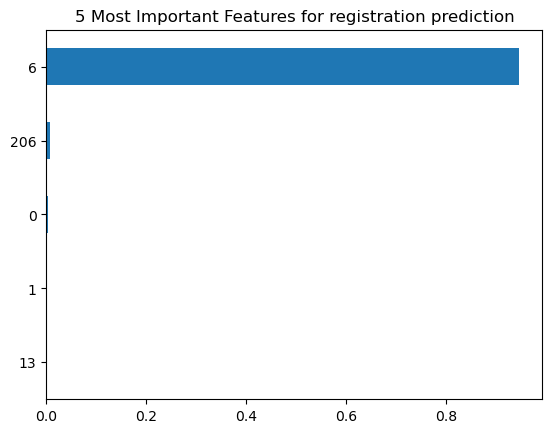

In [125]:
(pd.Series(clf.feature_importances_)
   .nlargest(5)
   .plot(kind='barh',title='5 Most Important Features for Home Remote prediction')).invert_yaxis()

In [109]:
X2 = sm.add_constant(np.array(X_train.values,dtype=float))
est = sm.OLS(y_train.values, X2)
est2 = est.fit()
print(est2.summary())

NameError: name 'sm' is not defined

In [108]:
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=80, max_samples=500, max_features=0.5, min_samples_leaf=5)
clf.fit(X_train.values, y_train.values)

In [55]:
# To prepare data cleaning we first need to know how many answers we have to the Home Remote question
prop_sals = 1 - df.isnull()['HomeRemote'].mean()
prop_sals

0.8563200498132005

we have ~14% of respondents not answering to the question. By categorizing Home Remote as a categorical variable 'RemotePossible' I categorized null values to 0, not possible to work from home. I feel that for this particular question it makes more sense to remove them completely from the dataset. 

In [29]:
# In order to predict job satisfaction later, I decide to create a new categorical variable
def higher_js(higher_js_float):
    """
    INPUT
        higher_js_float - a float of one of the values from the Job Satisfaction variable

    OUTPUT
        return 1 if the float is bigger or equal to 7
        return 0 otherwise

    """
    if higher_js_float >= 7:
        return 1
    else:
        return 0


df["JobSatisfaction"].apply(higher_js)[
    :5
]  # Test your function to assure it provides 1 and 0 values for the df


0    0
1    0
2    1
3    0
4    1
Name: JobSatisfaction, dtype: int64

In [30]:
df["HigherJs"] = df["JobSatisfaction"].apply(higher_js)
higher_js_perc = df["HigherJs"].mean()
higher_js_perc


0.5190107409713575

In [31]:
js_1 = df[df["HigherJs"] == 1]  # Subset df to only those with JobSat of 1
js_0 = df[df["HigherJs"] == 0]  # Subset df to only those with JobSat of 0

print(js_1["HigherJs"][:5])  # Assure it looks like what you would expect
print(js_0["HigherJs"][:5])  # Assure it looks like what you would expect


2     1
4     1
7     1
9     1
10    1
Name: HigherJs, dtype: int64
0    0
1    0
3    0
5    0
6    0
Name: HigherJs, dtype: int64


In [41]:
res = df.groupby(["FormalEducation"]).mean()["JobSatisfaction"].sort_values().dropna()
res


FormalEducation
I never completed any formal education                               6.833333
Bachelor's degree                                                    6.866363
Master's degree                                                      6.953151
Primary/elementary school                                            6.956897
I prefer not to answer                                               7.005682
Some college/university study without earning a bachelor's degree    7.081334
Professional degree                                                  7.087459
Secondary school                                                     7.143082
Doctoral degree                                                      7.348857
Name: JobSatisfaction, dtype: float64

In [42]:
def clean_data(df):
    """
    INPUT
    df - pandas dataframe

    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector

    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    """
    # Drop rows with missing salary values
    df = df.dropna(subset=["Salary"], axis=0)
    y = df["Salary"]

    # Drop respondent and expected salary columns
    df = df.drop(["Respondent", "ExpectedSalary", "Salary"], axis=1)

    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=["float", "int"]).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)

    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=["object"]).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat(
            [
                df.drop(var, axis=1),
                pd.get_dummies(df[var], prefix=var, prefix_sep="_", drop_first=True),
            ],
            axis=1,
        )

    X = df
    return X, y


# Use the function to create X and y
X, y = clean_data(df)


In [25]:
# Only use quant variables and drop any rows with missing values
num_vars = df[
    [
        "Salary",
        "CareerSatisfaction",
        "HoursPerWeek",
        "JobSatisfaction",
        "StackOverflowSatisfaction",
    ]
]

# Drop the rows with missing salaries
drop_sal_df = num_vars.dropna(subset=["Salary"], axis=0)

# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
fill_df = drop_sal_df.apply(fill_mean, axis=0)

# Split into explanatory and response variables
X = fill_df[
    [
        "CareerSatisfaction",
        "HoursPerWeek",
        "JobSatisfaction",
        "StackOverflowSatisfaction",
    ]
]
y = fill_df["Salary"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

lm_model = LinearRegression(normalize=True)  # Instantiate
lm_model.fit(X_train, y_train)  # Fit

# Predict and score the model
y_test_preds = lm_model.predict(X_test)
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(
    r2_score(y_test, y_test_preds), len(y_test)
)


c:\Users\Ramona\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





'The r-squared score for the model using only quantitative variables was 0.04072431792894726 on 3868 values.'